## Problem.1
年金がない場合、横軸に若年期期初の利子を除く資産、縦軸に次期の利子を除く資産とする貯蓄の政策関数のグラフをそれぞれの生産性について描け。
全て同じ1つの図に描くこと。異なる生産性での貯蓄行動を比較し、その経済学的な直感も述べよ

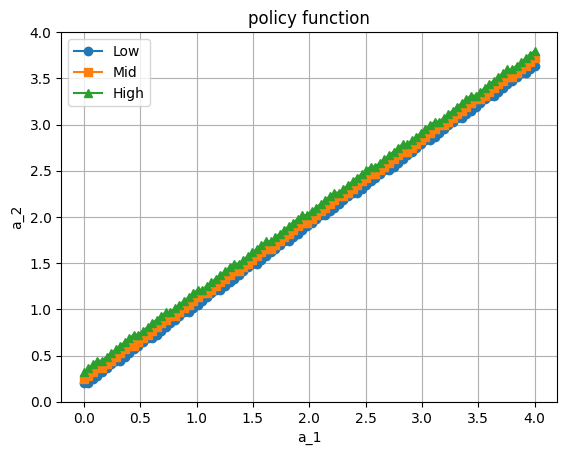

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])
mu_1 = np.array([1.0/NL, 1.0/NL, 1.0/NL])
mu_2 = np.zeros(NL)

for il in range(NL):
    for ilp in range(NL):
        mu_2[ilp] += prob[il, ilp]*mu_1[il]

# grids
a_l = 0.0
a_u = 4.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# initialization
v_no_pension = np.zeros((JJ, NA, NL))
iaplus_no_pension = np.zeros((JJ-1, NA, NL), dtype=int) # no job earnings in period 3
aplus_no_pension = np.zeros((JJ - 1, NA, NL)) 

# Utility function

def util(cons, gamma):
    return max(cons, 1e-4)**(1.0-gamma)/(1.0-gamma)

# backward induction

# Period 3
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0 + r) * a[ia], gamma) # no income, only savings.

# Period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta * v_no_pension[2, iap, 0]
        iaplus_no_pension[1, ia, il] = np.argmax(reward)
        aplus_no_pension[1, ia, il] = a[iaplus_no_pension[1, ia, il]]
        v_no_pension[1, ia, il] = reward[iaplus_no_pension[1, ia, il]]

# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            
            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp]*v_no_pension[1, iap, ilp]
            
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta * EV
        
        iaplus_no_pension[0, ia, il] = np.argmax(reward)
        aplus_no_pension[0, ia, il] = a[iaplus_no_pension[0, ia, il]]
        v_no_pension[0, ia, il] = reward[iaplus_no_pension[0, ia, il]]

plt.figure()
plt.plot(a, aplus_no_pension[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus_no_pension[0, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_no_pension[0, :, 2], marker='^', label='High')
plt.title("policy function")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()

####  Verifying that a simulation model is working correctly

[0.33333333 0.33333333 0.33333333]
[0.2944     0.41123333 0.2944    ]


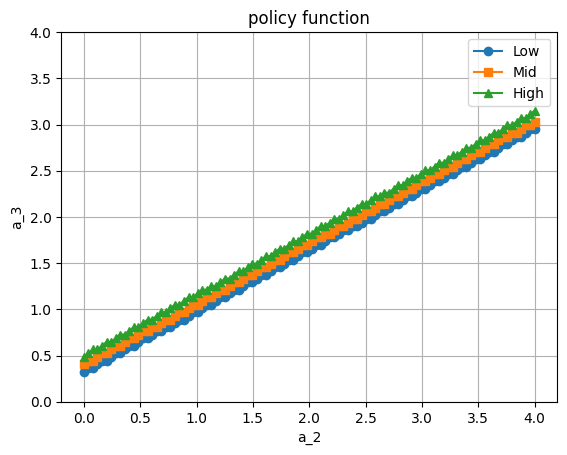

In [2]:
# checking the distribution of the population across the different productivity levels
print(mu_1)
print(mu_2)

# checking whether a_3 increases. Hypothesis: a_3 increases than the previous model (income exists in period 3).
plt.figure()
plt.plot(a, aplus_no_pension[1, :, 0], marker='o', label='Low')
plt.plot(a, aplus_no_pension[1, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_no_pension[1, :, 2], marker='^', label='High')
plt.title("policy function")
plt.xlabel("a_2")
plt.ylabel("a_3")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()

## Problem.2
老年期にすべての個人に年金を支給することを考える。
そのための原資として、中年期にのみ労働所得に対して定率30%の所得税を課す。
中年期における政府の総税収はいくらか？
政府はその総税収を利子率個人の資産と同じ利子率で運用し、老年期にそこから個人個人に均等に定額の年金を給付する。
一人当たりの年金額を求めよ

In [3]:
tax_rate = 0.30

# Calculate average labor income in middle age
labor_income_mid = np.sum(mu_2 * l)
total_tax_revenue = labor_income_mid * tax_rate

# Calculate the per-person pension benefit
pension_benefit = total_tax_revenue * (1.0 + r)

print(f"Total Tax Revenue: {total_tax_revenue:.4f}")
print(f"Per-Person Pension Benefit: {pension_benefit:.4f}")

Total Tax Revenue: 0.3043
Per-Person Pension Benefit: 0.4986


In [4]:
#Verifying the result
print(f"Average Labor Income in Middle age: {labor_income_mid:.4f}")

Average Labor Income in Middle age: 1.0143


## Problem.3
問2の年金が導入された場合の個人の最適化問題を再度解き、
問1と同様にグラフを描き、年金導入前と導入後の貯蓄行動を比較せよ。その経済学的な直感も述べよ。

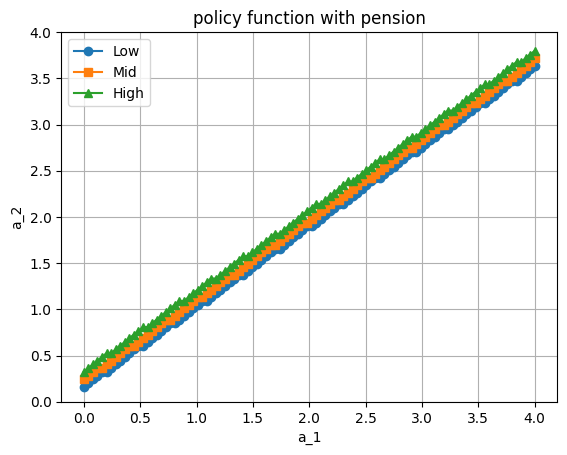

In [5]:
v_pension = np.zeros((JJ, NA, NL))
iaplus_pension = np.zeros((JJ-1, NA, NL), dtype=int)
aplus_pension = np.zeros((JJ - 1, NA, NL))

# Period 3 (with pension)
for ia in range(NA):
    v_pension[2, ia, :] = util((1.0 + r) * a[ia] + pension_benefit, gamma)
    
# Period 2 (with tax)
for il in range(NL):
    for ia in range(NA):
        reward_pension = np.zeros(NA)
        for iap in range(NA):
            # Income is now after-tax
            reward_pension[iap] = util(l[il] * (1 - tax_rate) + (1.0 + r) * a[ia] - a[iap], gamma) + beta * v_pension[2, iap, 0]
        iaplus_pension[1, ia, il] = np.argmax(reward_pension)
        aplus_pension[1, ia, il] = a[np.argmax(reward_pension)]
        v_pension[1, ia, il] = np.max(reward_pension)

# Period 1
for il in range(NL):
    for ia in range(NA):
        reward_pension = np.zeros(NA)
        for iap in range(NA):
            
            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp] * v_pension[1, iap, ilp]

            reward_pension[iap] = util(l[il] + (1.0 + r) * a[ia] - a[iap], gamma) + beta * EV
        
        iaplus_pension[0, ia, il] = np.argmax(reward_pension)
        aplus_pension[0, ia, il] = a[iaplus_pension[0, ia, il]]
        v_pension[0, ia, il] = reward_pension[iaplus_pension[0, ia, il]]
        
plt.figure()
plt.plot(a, aplus_pension[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus_pension[0, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_pension[0, :, 2], marker='^', label='High')
plt.title("policy function with pension")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()

## Problem.4
ここで全員の若年期の期初の資産をゼロとする。
若年期の異なる生産性タイプの期待生涯効用を人口比率で加重平均した「経済全体の平均期待生涯効用」は、年金導入によって増加するか、減少するか？
その経済学的な直感とともに、このシミュレーションによると日本で年金の制度は維持すべきなのか論じよ。

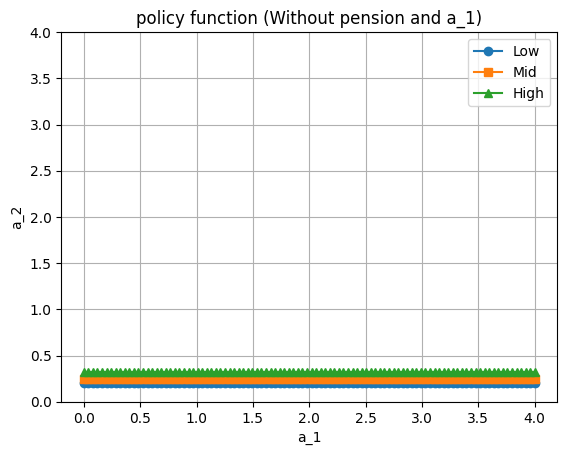

In [ ]:
# Modify problem 1 with no asset in period 1
# no pension
# initialization
v_no_p_a1 = np.zeros((JJ, NA, NL))
iaplus_no_p_a1 = np.zeros((JJ-1, NA, NL), dtype=int)
aplus_no_p_a1 = np.zeros((JJ - 1, NA, NL)) 

# backward induction

# Period 3
for ia in range(NA):
    v_no_p_a1[2, ia, :] = util((1.0 + r) * a[ia], gamma) 

# Period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            reward[iap] = util(l[il] + (1.0+r)*a[ia] - a[iap], gamma) + beta * v_no_p_a1[2, iap, 0]
        iaplus_no_p_a1[1, ia, il] = np.argmax(reward)
        aplus_no_p_a1[1, ia, il] = a[iaplus_no_p_a1[1, ia, il]]
        v_no_p_a1[1, ia, il] = reward[iaplus_no_p_a1[1, ia, il]]

# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.zeros(NA)
        for iap in range(NA):
            
            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp]*v_no_p_a1[1, iap, ilp]
            
            reward[iap] = util(l[il] - a[iap], gamma) + beta * EV # no asset 1
        
        iaplus_no_p_a1[0, ia, il] = np.argmax(reward)
        aplus_no_p_a1[0, ia, il] = a[iaplus_no_p_a1[0, ia, il]]
        v_no_p_a1[0, ia, il] = reward[iaplus_no_p_a1[0, ia, il]]

plt.figure()
plt.plot(a, aplus_no_p_a1[0, :, 0], marker='o', label='Low')
plt.plot(a, aplus_no_p_a1[0, :, 1], marker='s', label='Mid')
plt.plot(a, aplus_no_p_a1[0, :, 2], marker='^', label='High')
plt.title("policy function (Without pension and a_1)")
plt.xlabel("a_1")
plt.ylabel("a_2")
plt.ylim(a_l, a_u)
plt.grid(True)
plt.legend()
plt.show()


In [7]:
# --- Problem 4 Solution ---

# Index for zero initial assets (since a_l = 0.0, the first element is 0)
ia_zero_asset = 0

# --- Get the utility values for each type, starting with zero assets ---
# Scenario 1: No Pension
utility_no_pension_low = v_no_pension[0, ia_zero_asset, 0]
utility_no_pension_med = v_no_pension[0, ia_zero_asset, 1]
utility_no_pension_high = v_no_pension[0, ia_zero_asset, 2]

# Scenario 2: With Pension
utility_with_pension_low = v_pension[0, ia_zero_asset, 0]
utility_with_pension_med = v_pension[0, ia_zero_asset, 1]
utility_with_pension_high = v_pension[0, ia_zero_asset, 2]

# Initial population distribution (1/3 for each type)
mu_1 = np.full(NL, 1.0/NL)

# --- Calculate the overall average expected lifetime utility for each scenario ---
avg_utility_no_pension = np.sum(mu_1 * v_no_pension[0, ia_zero_asset, :])
avg_utility_with_pension = np.sum(mu_1 * v_pension[0, ia_zero_asset, :])


# --- Print a formatted table and the final conclusion ---

print("--- Expected Lifetime Utility (Starting with Zero Assets) ---")
print(f"{'Productivity Type':<20} | {'No Pension':<15} | {'With Pension':<15}")
print("-" * 55)
# Corrected Print Statements:
print(f"{'Low (0.8027)':<20} | {utility_no_pension_low:<15.4f} | {utility_with_pension_low:<15.4f}")
print(f"{'Medium (1.0)':<20} | {utility_no_pension_med:<15.4f} | {utility_with_pension_med:<15.4f}")
print(f"{'High (1.2457)':<20} | {utility_no_pension_high:<15.4f} | {utility_with_pension_high:<15.4f}")

print("\n--- Overall Average Expected Lifetime Utility ---")
print(f"Without Pension: {avg_utility_no_pension:.4f}")
print(f"With Pension:    {avg_utility_with_pension:.4f}")
print("-" * 55)

# Determine if utility increases or decreases and print conclusion
if avg_utility_with_pension > avg_utility_no_pension:
    print("\nResult: Overall average expected lifetime utility INCREASES with the pension system.")
else:
    print("\nResult: Overall average expected lifetime utility DECREASES with the pension system.")

--- Expected Lifetime Utility (Starting with Zero Assets) ---
Productivity Type    | No Pension      | With Pension   
-------------------------------------------------------
Low (0.8027)         | -3.4178         | -3.3355        
Medium (1.0)         | -2.8014         | -2.7944        
High (1.2457)        | -2.2957         | -2.3301        

--- Overall Average Expected Lifetime Utility ---
Without Pension: -2.8383
With Pension:    -2.8200
-------------------------------------------------------

Result: Overall average expected lifetime utility INCREASES with the pension system.


In [8]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# --- Grids ---
# A larger asset grid is necessary for the model to find valid solutions
a_l = 0.0
a_u = 25.0
NA = 1000
a = np.linspace(a_l, a_u, NA)

# --- Utility Function ---
def util(c, gamma):
    if c > 0:
        return (c**(1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# --- 1. Solve for Policy Function WITHOUT Pension ---
v_no_pension = np.zeros((JJ, NA, NL))
aplus_no_pension = np.zeros((JJ - 1, NA, NL))
# Period 3
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0 + r) * a[ia], gamma)
# Period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_no_pension[2, iap, 0]
        aplus_no_pension[1, ia, il] = a[np.argmax(reward)]
        v_no_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_no_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_no_pension[0, ia, il] = a[np.argmax(reward)]
        v_no_pension[0, ia, il] = np.max(reward)


# --- 2. Calculate Tax Revenue and Pension Benefit ---
tax_rate = 0.30
mu_1 = np.full(NL, 1.0/NL)
mu_2 = mu_1 @ prob
average_labor_income_mid = np.sum(mu_2 * l)
total_tax_revenue = average_labor_income_mid * tax_rate
pension_benefit = total_tax_revenue * (1.0 + r)


# --- 3. Solve for Policy Function WITH Pension ---
v_pension = np.zeros((JJ, NA, NL))
aplus_pension = np.zeros((JJ - 1, NA, NL))
# Period 3 (with pension)
for ia in range(NA):
    consumption = (1.0 + r) * a[ia] + pension_benefit
    v_pension[2, ia, :] = util(consumption, gamma)
# Period 2 (with tax)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] * (1 - tax_rate) + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_pension[2, iap, 0]
        aplus_pension[1, ia, il] = a[np.argmax(reward)]
        v_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_pension[0, ia, il] = a[np.argmax(reward)]
        v_pension[0, ia, il] = np.max(reward)


# --- 4. Calculate and Display Final Results for Problem 4 ---
ia_zero_asset = 0

# Get utility values for each type, starting with zero assets
utility_no_pension_low = v_no_pension[0, ia_zero_asset, 0]
utility_no_pension_med = v_no_pension[0, ia_zero_asset, 1]
utility_no_pension_high = v_no_pension[0, ia_zero_asset, 2]
utility_with_pension_low = v_pension[0, ia_zero_asset, 0]
utility_with_pension_med = v_pension[0, ia_zero_asset, 1]
utility_with_pension_high = v_pension[0, ia_zero_asset, 2]

# Calculate overall average expected utility for each scenario
avg_utility_no_pension = np.sum(mu_1 * v_no_pension[0, ia_zero_asset, :])
avg_utility_with_pension = np.sum(mu_1 * v_pension[0, ia_zero_asset, :])

# Print formatted table and conclusion
print("--- Expected Lifetime Utility (Starting with Zero Assets) ---")
print(f"{'Productivity Type':<20} | {'No Pension':<15} | {'With Pension':<15}")
print("-" * 55)
print(f"{'Low (0.8027)':<20} | {utility_no_pension_low:<15.4f} | {utility_with_pension_low:<15.4f}")
print(f"{'Medium (1.0)':<20} | {utility_no_pension_med:<15.4f} | {utility_with_pension_med:<15.4f}")
print(f"{'High (1.2457)':<20} | {utility_no_pension_high:<15.4f} | {utility_with_pension_high:<15.4f}")

print("\n--- Overall Average Expected Lifetime Utility ---")
print(f"Without Pension: {avg_utility_no_pension:.4f}")
print(f"With Pension:    {avg_utility_with_pension:.4f}")
print("-" * 55)

if avg_utility_with_pension > avg_utility_no_pension:
    print("\nResult: Overall average expected lifetime utility INCREASES with the pension system.")
else:
    print("\nResult: Overall average expected lifetime utility DECREASES with the pension system.")

--- Expected Lifetime Utility (Starting with Zero Assets) ---
Productivity Type    | No Pension      | With Pension   
-------------------------------------------------------
Low (0.8027)         | -3.4151         | -3.3358        
Medium (1.0)         | -2.8018         | -2.7945        
High (1.2457)        | -2.2957         | -2.3297        

--- Overall Average Expected Lifetime Utility ---
Without Pension: -2.8375
With Pension:    -2.8200
-------------------------------------------------------

Result: Overall average expected lifetime utility INCREASES with the pension system.
